In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [22]:
# Шаг 1: Загрузка данных о времени

data = pd.read_csv('Time_Series_clients_2016-2019.csv')
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

In [23]:
data.head()

,came
date,
2016-01-10,1345
2016-01-17,2066
2016-01-24,1979
2016-01-31,1909
2016-02-07,1575


In [24]:
# Шаг 2: Тест Дики-Фуллера для проверки стационарности

def adf_test(timeseries):
    result = adfuller(timeseries)
    print('Статистика ADF :', result[0])
    print('p-value :', result[1])
    print('Критические значения :')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

adf_test(data['came'])

Статистика ADF : -1.293736019906016
p-value : 0.632033197296583
Критические значения :
	1%: -3.47086589632514
	5%: -2.879330279087651
	10%: -2.57625492712671


In [25]:
# Шаг 3: Декомпозиция временного ряда

decomposition = sm.tsa.seasonal_decompose(data['came'], model='additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

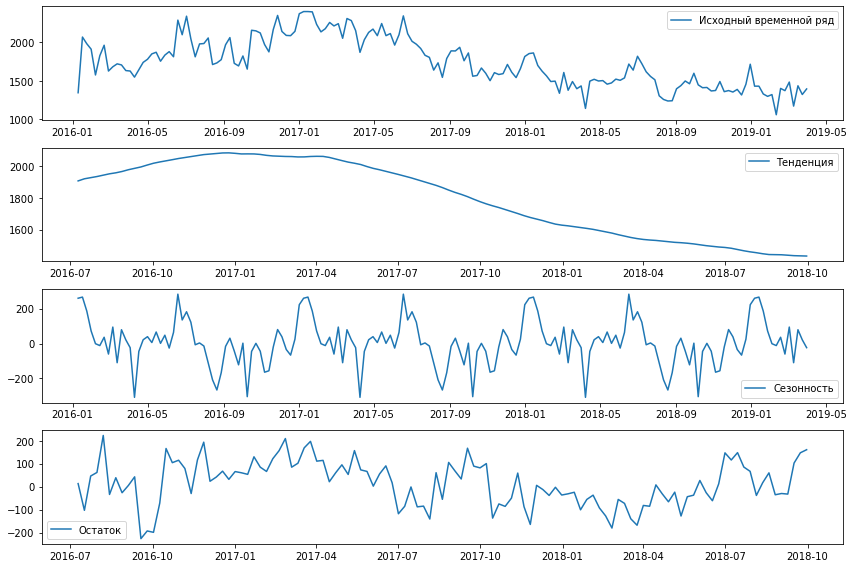

In [29]:
# Построить график разложенных компонентов

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(data['came'], label='Исходный временной ряд')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Тенденция')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Сезонность')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Остаток')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [30]:
# Шаг 4: преобразование Бокса-Кокса и тест Дики-Фуллера

from scipy.stats import boxcox
data_transformed, lambda_ = boxcox(data['came'])
adf_test(data_transformed)

Статистика ADF : -1.4972692876443763
p-value : 0.5348617481593065
Критические значения :
	1%: -3.470616369591229
	5%: -2.8792214018977655
	10%: -2.57619681359045


In [31]:
# Шаг 5: Обучение и прогнозирование модели ARIMA

train_data = data_transformed[:-12]
test_data = data_transformed[-12:]

model = sm.tsa.ARIMA(train_data, order=(1, 1, 1))
model_fit = model.fit()
predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

In [32]:
# Шаг 6: Рассчитать показатели оценки

def evaluate_forecast(predictions, test_data):
    mape = np.mean(np.abs((predictions - test_data) / test_data)) * 100
    smape = np.mean(2 * np.abs(predictions - test_data) / (np.abs(predictions) + np.abs(test_data))) * 100
    mae = np.mean(np.abs(predictions - test_data))
    return mape, smape, mae

mape, smape, mae = evaluate_forecast(predictions, test_data)
print("MAPE:", mape)
print("SMAPE:", smape)
print("MAE:", mae)

MAPE: 1.7968596188655321
SMAPE: 1.7649946462822612
MAE: 0.1993003066346611


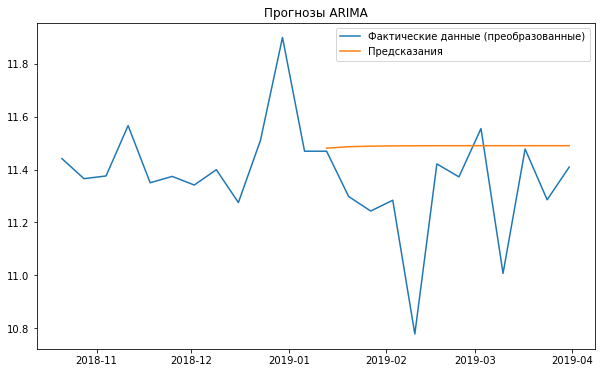

In [33]:
# Шаг 7: Отображение прогнозов

plt.figure(figsize=(10, 6))
plt.plot(data.index[-24:], data_transformed[-24:], label='Фактические данные (преобразованные)')
plt.plot(data.index[-12:], predictions, label='Предсказания')
plt.legend(loc='best')
plt.title("Прогнозы ARIMA")
plt.show()